In [6]:
#conda install -c conda-forge pyarrow

In [168]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [175]:
db = pd.read_parquet('db_P4.parquet.gzip')
#Energy_Star_Score = db['ENERGYSTARScore']
db = db.drop(columns=['log_SiteEnergyUseWN(kBtu)']) # On supprime la cible 2 pour éviter toute confusion
db

,index,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,...,0.0,0.0,0.0,0.044629,0.000000,0.0,0.0,0.0,0.0,0.0
2,2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,1462,50054,47.62251,-122.33390,2014,1.0,13,0.368288,0.631712,0.749734,...,0.0,0.0,0.0,0.000000,0.011763,0.0,0.0,0.0,0.0,0.0
942,1463,50062,47.65476,-122.34732,2014,1.0,4,0.327535,0.672465,0.681123,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
943,1464,50068,47.54425,-122.31776,1955,1.0,1,0.081060,0.918940,0.203226,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
944,1465,50069,47.53161,-122.29944,1929,1.0,2,0.000000,1.000000,0.490206,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [176]:
Energy_Star_Score # On le conserve pour le tester sur notre modèle final

0       60.0
1       61.0
2       43.0
3       56.0
4       75.0
        ... 
1462    98.0
1463    72.0
1464    37.0
1465     9.0
1467    77.0
Name: ENERGYSTARScore, Length: 946, dtype: float64

# Variables prédictives X & Cible y 

In [3]:
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import explained_variance_score,mean_absolute_error, r2_score,  mean_squared_error

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


import xgboost as xgb

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

from time import time


In [177]:
X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = np.array(X)
X

array([[ 0.0000000e+00,  4.7612200e+01, -1.2233799e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  4.7613170e+01, -1.2233393e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0000000e+00,  4.7613930e+01, -1.2233810e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 1.4640000e+03,  4.7544250e+01, -1.2231776e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4650000e+03,  4.7531610e+01, -1.2229944e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4670000e+03,  4.7588310e+01, -1.2230650e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]])

In [178]:
y = db['log_TotalGHGEmissions'].copy()
y = np.array(y)
y

array([5.52138091, 5.68988637, 7.64457479, 5.65749418, 6.22457823,
       5.17127913, 5.97166992, 6.53851602, 6.60796014, 5.79371458,
       6.47484703, 6.23713251, 6.68821772, 5.85598841, 7.14305662,
       4.49992078, 5.7949325 , 4.85546187, 5.37063803, 9.73335027,
       3.44903471, 4.87183289, 4.42914874, 5.51282372, 5.68809338,
       4.19690115, 3.56558124, 4.08075261, 7.80448799, 4.90067161,
       5.42574265, 4.97528442, 5.29806734, 5.09000085, 5.02886806,
       4.98593268, 5.14539926, 4.47710952, 4.20558774, 6.06573679,
       5.57120301, 3.66509893, 4.93339421, 6.26691588, 6.42571146,
       6.51336363, 3.8869103 , 5.02480115, 5.25332   , 4.36754731,
       5.4940075 , 3.53046972, 4.84646795, 6.09521627, 4.48886106,
       4.95856977, 7.59614114, 5.43109848, 5.40618474, 3.90358753,
       6.58405908, 4.1941899 , 9.00522336, 4.42723898, 4.24046307,
       5.6951789 , 3.57738908, 5.91117598, 5.60892219, 5.73528114,
       5.82351916, 5.3387873 , 3.34180117, 5.96195849, 2.82197

# Train & Test Split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2023)

# Modèle 

In [180]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror' ,n_jobs= -1)
lg = lgb.LGBMRegressor(n_jobs=-1)

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    xg_reg,
    lg,
    SGDRegressor()
    
    
]

In [181]:
#head = 11
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.003s
	Explained variance: 0.1084690142693776
	Mean absolute error: 1.138927915078663
	R2 score: 0.10796688701974144

GradientBoostingRegressor()
	Training time: 0.141s
	Prediction time: 0.000s
	Explained variance: 0.7589776219155776
	Mean absolute error: 0.5724899990789818
	R2 score: 0.7559695186572003

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.017s
	Explained variance: 0.1084690142693776
	Mean absolute error: 1.138927915078663
	R2 score: 0.10796688701974144

ExtraTreesRegressor()
	Training time: 0.267s
	Prediction time: 0.014s
	Explained variance: 0.754659494606136
	Mean absolute error: 0.5689354281990261
	R2 score: 0.7546477913876924

RandomForestRegressor()
	Training time: 0.301s
	Prediction time: 0.016s
	Explained variance: 0.7490522588195375
	Mean absolute error: 0.5884219740320695
	R2 score: 0.7486217077828677

DecisionTreeRegressor()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained 

## Grid search CV

In [9]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
#               'learning_rate' : (0.05,0.25,0.50,1),
#               'criterion' : ['friedman_mse', 'mse', 'mae'],
#               'max_features' : ['auto', 'sqrt', 'log2']
#              }

In [ ]:
# grid = GridSearchCV(GradientBoostingRegressor(),parameters)
# model = grid.fit(X_train,y_train)
# print(model.best_params_,'\n')
# print(model.best_estimator_,'\n')

## Régression linéaire 

In [ ]:
# reg = LinearRegression().fit(X_train, y_train) # Régression linéaire

In [ ]:
# reg.score(X, y) # R2

In [ ]:
# y_pred = reg.predict(X_test) # Prédiction sur X_test

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

In [ ]:
# # The coefficients
# print("Coefficients: \n", reg.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Cross validation

In [ ]:
# cross_val_score(LinearRegression(),X_train,y_train,cv=5)#,scoring='r2')

In [ ]:
# from sklearn.model_selection import KFold

In [ ]:
# # Create 5 folds
# seed = 7
# kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# # Create a model 
# model = LinearRegression()

# # Train and evaluate multiple models using kfolds
# results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
# print(results)
# print("Mean:", results.mean())
# print("Std:", results.std())

In [ ]:
# 

# Fonction ML avec cross validation 
    Comparer les modèles

In [10]:
# Fonction 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def ML (model, X = X_train, y = y_train, param = None):
    
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

    if param is not None:
        
        gs = GridSearchCV(model, param_grid = param, cv = kfold, scoring = 'r2').fit(X,y)
        print(gs.best_params_)
        model.set_params(**gs.best_params_)
    
    list_pred = []
    list_val = []

    start = time()
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)
    
    for train, test in kfold:
        list_pred.append(model.fit(X[train],y[train]).predict(X[test]))
        list_val.append(y[test])
        
    end = time()
    
    list_pred = np.concatenate(list_pred)
    list_val = np.concatenate(list_val)


    print('\n',model,
                 '\n MSE : ', mean_squared_error(list_pred,list_val),
                 '\n R2 : ', r2_score(list_pred,list_val),
                 '\n Prédictions : ' , list_pred[:10], 
                 '\n Valeurs : ' , list_val[:10],
                 '\n Time' , end-start) 
    
    result = {'model' : model,
            'MSE' : mean_squared_error(list_pred,list_val),
            'R2' : mean_squared_error(list_pred,list_val),
            'Prédictions' : list_pred,
            'Valeurs' : list_val,
            'Time' : end-start
             }
    
    if param is not None : 
        result['Best Params'] = gs.best_params_ 

    return result
                

In [ ]:
?list_pred

###  Test 

In [11]:
test = ML(LinearRegression()) #OK !


 LinearRegression() 
 MSE :  1.0220306136287567 
 R2 :  0.2883797044306937 
 Prédictions :  [2.30435354 2.2830803  5.52577248 3.4776339  4.55027528 3.80345456
 3.01533762 5.52380538 1.90748239 3.30264007] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.0727219  3.06152001
 1.98375629 5.78916475 1.06815308 2.0135688 ] 
 Time 0.02643728256225586


In [ ]:
test

In [12]:
for model in regressors:
    ML(model)


 KNeighborsRegressor() 
 MSE :  1.721400007388838 
 R2 :  -1.191688359332495 
 Prédictions :  [3.280908   4.18977997 2.98504143 4.12779339 4.63877379 4.50432599
 2.91056244 4.34218143 2.70762295 3.6453371 ] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.0727219  3.06152001
 1.98375629 5.78916475 1.06815308 2.0135688 ] 
 Time 0.047278404235839844

 GradientBoostingRegressor() 
 MSE :  0.7371049947188133 
 R2 :  0.41488930865202345 
 Prédictions :  [2.15287752 2.59550917 4.51340434 3.2081592  5.32152858 3.52107335
 2.28461596 5.31718193 1.46008191 2.90915381] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.0727219  3.06152001
 1.98375629 5.78916475 1.06815308 2.0135688 ] 
 Time 1.7712328433990479

 KNeighborsRegressor() 
 MSE :  1.721400007388838 
 R2 :  -1.191688359332495 
 Prédictions :  [3.280908   4.18977997 2.98504143 4.12779339 4.63877379 4.50432599
 2.91056244 4.34218143 2.70762295 3.6453371 ] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.07

### ZIP avec Hyper Paramètres

In [ ]:
########################

# Utiliser ZIP
# For model in param in ZIP

# for model, param in zip(model_list, params_list):

In [13]:
model_list = [LinearRegression(),
              RandomForestRegressor(n_jobs= -1), # Parallélisation tous les CPU -1 
              xgb.XGBRegressor(n_jobs= -1 ),
              lgb.LGBMRegressor(n_jobs= -1)
             ]

params_list =  [None, # LinearRegressioin
                {'n_estimators' : [80, 100, 120] , # RF
                 'max_depth': [5, 10, 20, 25],
                 'min_samples_split': [2, 5, 8, 10],
                 'min_samples_leaf': [1, 2, 5]
                },
                { 'n_estimators' : [50,100,1000], # XGB
                 'max_depth' : [5, 10, 20],
                 'eta' : [0.01,0.1,0.5],
                 'subsample': [0.3,0.5,0.7],
                 'colsample_bytree' : [0.3,0.5,0.7]
                },
                {'n_estimators': [80, 100, 120, 150], # LGBM
                 'max_depth': [3, 5, 8, 10],
                 'num_leaves': [6, 8, 10]
                }
                
               
               ]



#zip_object = zip(model_list,params_list)


In [14]:
res = []
for model,param in zip(model_list,params_list):
    res.append(ML(model=model,param=param))


 LinearRegression() 
 MSE :  1.0220306136287567 
 R2 :  0.2883797044306937 
 Prédictions :  [2.30435354 2.2830803  5.52577248 3.4776339  4.55027528 3.80345456
 3.01533762 5.52380538 1.90748239 3.30264007] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.0727219  3.06152001
 1.98375629 5.78916475 1.06815308 2.0135688 ] 
 Time 0.018007278442382812
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 120}

 RandomForestRegressor(max_depth=20, min_samples_split=8, n_estimators=120,
                      n_jobs=-1) 
 MSE :  0.7756301488715334 
 R2 :  0.4219811874049879 
 Prédictions :  [2.557278   2.62550089 5.02761963 2.44798398 5.65599041 3.47629987
 2.09629189 5.69223543 1.25220589 3.16077807] 
 Valeurs :  [2.43185743 4.32134732 4.78197656 2.38232006 6.0727219  3.06152001
 1.98375629 5.78916475 1.06815308 2.0135688 ] 
 Time 1.6838245391845703
{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}

 XGBRegress

# PLot

## R2 MSE

In [98]:
res[0]

{'model': LinearRegression(),
 'MSE': 1.0220306136287567,
 'R2': 1.0220306136287567,
 'Prédictions': array([2.30435354, 2.2830803 , 5.52577248, ..., 3.72966702, 3.34827107,
        3.56717954]),
 'Valeurs': array([2.43185743, 4.32134732, 4.78197656, ..., 3.50435547, 4.05577697,
        4.49914278]),
 'Time': 0.018007278442382812}

In [97]:
list_res = [0,1,2,3]
for i in list_res:
        print(res[i]['R2'])


1.0220306136287567
0.7756301488715334
0.6516433389653464
0.7320437432494372


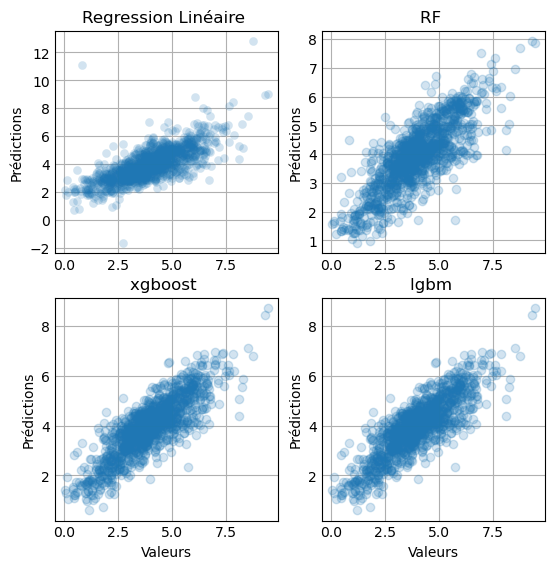

In [82]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)

plt.scatter(res[0]['Valeurs'],res[0]['Prédictions'],alpha=0.2, linewidths = .1)
plt.title('Regression Linéaire ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,2)

plt.scatter(res[1]['Valeurs'],res[1]['Prédictions'],alpha=0.2)
plt.title('RF ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,3)

plt.scatter(res[2]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
plt.title('xgboost ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.subplot(2,2,4)

plt.scatter(res[3]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
plt.title('lgbm ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.show()



# Final model 

In [ ]:
# best_parameters = max_depth=3, n_estimators=150, num_leaves=8

In [105]:
final_model = lgb.LGBMRegressor(max_depth=3, n_estimators=150, num_leaves=8, n_jobs=-1)

In [106]:
final_model.fit(X_train,y_train)

LGBMRegressor(max_depth=3, n_estimators=150, num_leaves=8)

In [110]:
pred = final_model.predict(X_test)

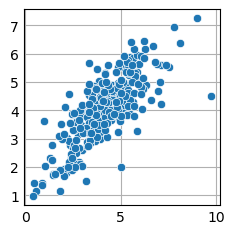

In [121]:
import seaborn as sns
sns.scatterplot(x= y_test , y=pred)
plt.show()

In [124]:
mean_squared_error(pred,y_test),r2_score(pred,y_test)

(0.8739669039677433, 0.3041021462504476)

# final XGB 

In [130]:
final_xgb =  xgb.XGBRegressor( max_depth=3, n_estimators=150,n_jobs= -1) 

In [131]:
final_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [132]:
pred_xgb = final_xgb.predict(X_test)

In [133]:
mean_squared_error(pred_xgb,y_test),r2_score(pred_xgb,y_test)

(0.808189802517532, 0.4229248152011764)

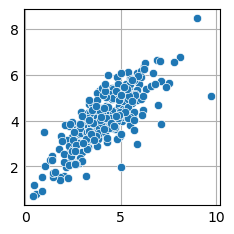

In [134]:
sns.scatterplot(x= y_test , y=pred_xgb)
plt.show()

# SHAP 

In [136]:
#conda install -c conda-forge shap

In [137]:
import shap 

In [139]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

In [140]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

## Shap Features Importances

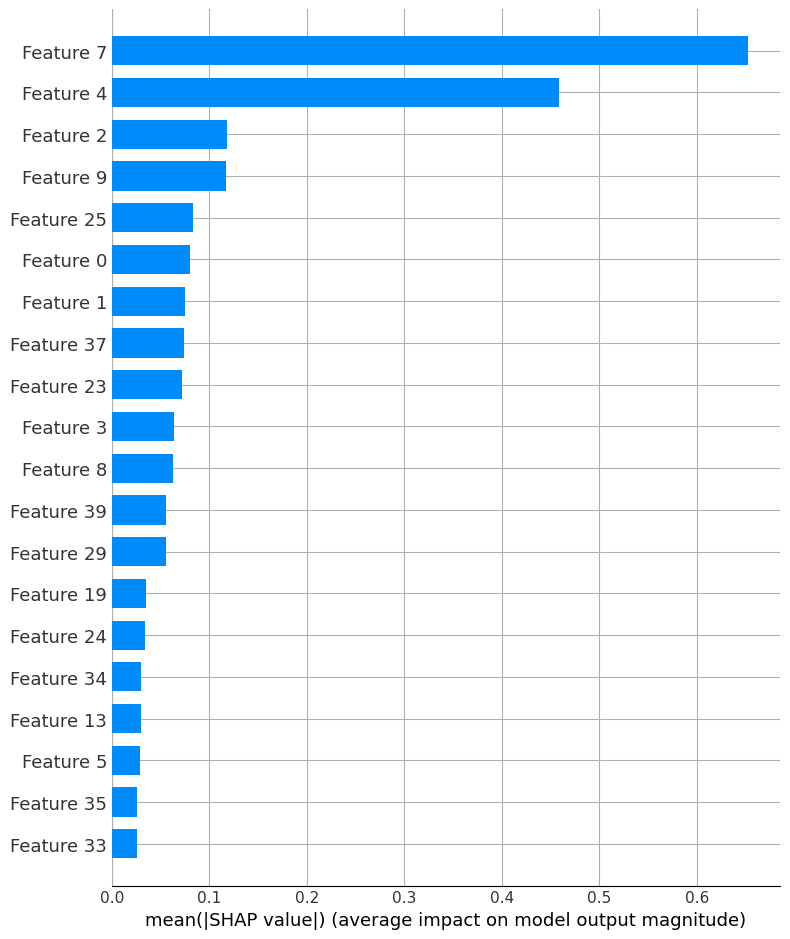

In [142]:
shap_values = shap.TreeExplainer(final_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

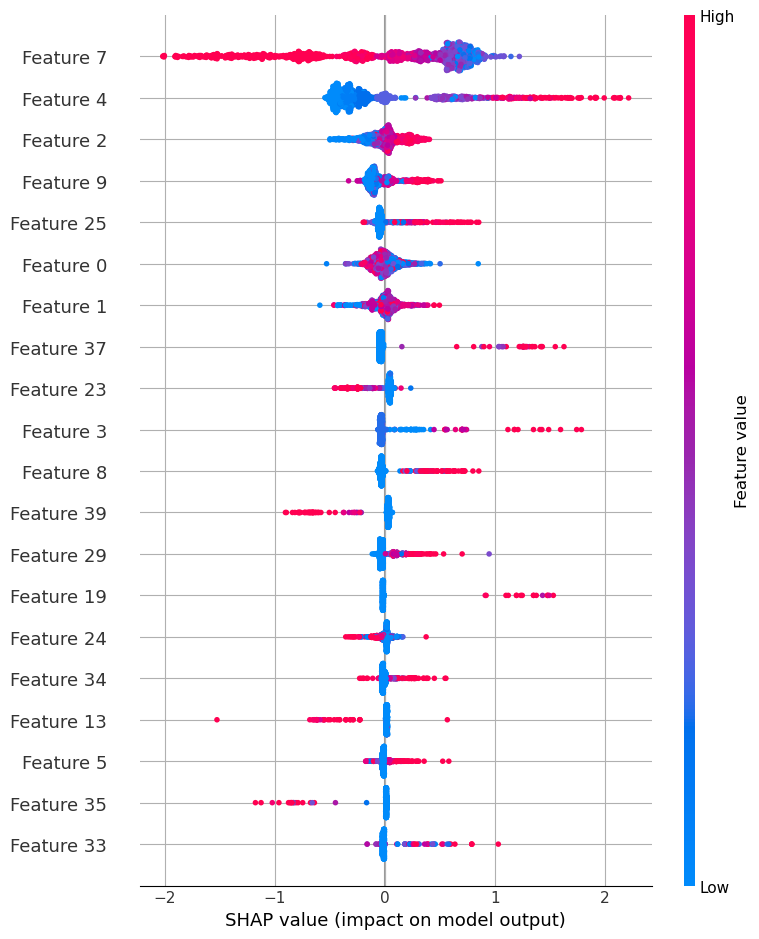

In [160]:
shap.summary_plot(shap_values, X_train)

# Energy Star Score 

In [182]:
# On conserve cette fois ci Energy Star Score 
# y demeure inchangé
X_Star_Score = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID']).copy() 
X_Star_Score = np.array(X_Star_Score)
X_Star_Score

array([[ 0.0000000e+00,  4.7612200e+01, -1.2233799e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  4.7613170e+01, -1.2233393e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0000000e+00,  4.7613930e+01, -1.2233810e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 1.4640000e+03,  4.7544250e+01, -1.2231776e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4650000e+03,  4.7531610e+01, -1.2229944e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4670000e+03,  4.7588310e+01, -1.2230650e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]])

In [183]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_Star_Score, y, test_size=0.2 , random_state = 2023)

In [186]:
final_xgb.fit(X_train_2,y_train_2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [188]:
pred_star_score = final_xgb.predict(X_test_2)

In [189]:
mean_squared_error(pred_star_score,y_test_2),r2_score(pred_star_score,y_test_2)

(0.4828420425452411, 0.7796312895654535)

- Beaucoup mieux avec Energy Star Score 

In [ ]:
# ML(RandomForestRegressor(),param= {'n_estimators' : [80, 100, 120]
# } )

In [16]:
from multiprocessing import Pool
import os
cpuCount = os.cpu_count()
cpuCount

12

In [ ]:
# support vector regression 

# •C: [5, 10, 20]
# •gamma: ['scale', 'auto']
# •kernel: ['poly', 'rbf', 'linear’]
# •epsilon: [0.05, 0.1, 0.3, 1]

# lightGBM:
# •n_estimators: [80, 100, 120, 150]
# •max_depth: [3, 5, 8, 10]
# •num_leaves: [6, 8, 10]

# Arbre de decisions:

# •max_depth: [8, 10, 12]
#       min_samples_split: [5, 8, 10, 12]
# •min_samples_leaf: [1, 2, 3]
# •splitter : ['best', 'random']

# XGboost : 
#     'regressor__learning_rate' : [0.01, 0.1, 0.5],
#     'regressor__gamma': [0, 0.5, 1.0],
#     'regressor__max_depth': [5, 10, 20],
#     'regressor__min_child_weight' : [1, 5, 10],
#     'regressor__n_estimators': [50, 100, 1000]

In [ ]:
for params_list in model_list in zip(model_list,params_list)

In [ ]:
# Fonction 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


def ML_hyper (model, X = X_train, y = y_train, param = zip_object):
    
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

    if param is not None:
        
        gs = GridSearchCV(model, param_grid = param, cv = kfold, scoring = 'r2').fit(X,y)
        print(gs.best_params_)
        model.set_params(**gs.best_params_)
    
    list_pred = []
    list_val = []

    start = time()
    
    for train, test in kfold:
        list_pred.append(model.fit(X[train],y[train]).predict(X[test]))
        list_val.append(y_train[test])
        
    end = time()
    
    list_pred = np.concatenate(list_pred)
    list_val = np.concatenate(list_val)

    print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))
    
    
    return     mean_squared_error(list_pred,list_val),r2_score(list_pred,list_val), list_pred,list_val,end-start

In [ ]:
ML_hyper(LinearRegression())

In [ ]:
###############################################

In [ ]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(LinearRegression().fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

In [ ]:
pred = LinearRegression().fit(X_train,y_train).predict(X_test)
print(
    mean_squared_error(pred,y_test),
    r2_score(pred,y_test))

# RF 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(RandomForestRegressor().fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

In [ ]:
params = { 'n_estimators' : [80, 100, 120] ,
          'max_depth': [5, 10, 20, 25],
          'min_samples_split': [2, 5, 8, 10],
          #'min_samples_leaf': [1, 2, 5]

}

In [ ]:
rf = RandomForestRegressor()
grid = GridSearchCV(rf, param_grid = params, cv = 5, scoring ='r2' )
result = grid.fit(X_train, y_train)

In [ ]:
result.best_params_, result.best_score_

In [ ]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(RandomForestRegressor(max_depth = 20 , min_samples_leaf = 1, min_samples_split = 2, n_estimators =120).fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    print(r2_score(list_pred[len(list_pred)-1],list_val[len(list_val)-1]))
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

In [ ]:
import seaborn as sns


In [ ]:
sns.scatterplot(x=list_pred,y=list_val)
plt.show()

# SVM 

In [ ]:
from sklearn import svm
regr = svm.SVR()
regrl = svm.LinearSVR()

In [ ]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(regr.fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

In [ ]:
pred = svm.SVR().fit(X_train,y_train).predict(X_test)
print(
    mean_squared_error(pred,y_test),
    r2_score(pred,y_test))

# XG boost 

In [ ]:
import xgboost as xgb

In [ ]:
# <!-- XGboost : 
#     'regressor__learning_rate' : [0.01, 0.1, 0.5],
#     'regressor__gamma': [0, 0.5, 1.0],
#     'regressor__max_depth': [5, 10, 20],
#     'regressor__min_child_weight' : [1, 5, 10],
#     'regressor__n_estimators': [50, 100, 1000] -->

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
#xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror' ,n_jobs= 6)

In [ ]:
xg_reg = xgb.XGBRegressor(n_jobs= -1 )

- n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [ ]:
param_xgb = {
    'regressor_learning_rate' : [0.01, 0.1, 0.5],
    'regressor_gamma': [0, 0.5, 1.0],
    'regressor_max_depth': [5, 10, 20],
    'regressor_min_child_weight' : [1, 5, 10],
    'regressor_n_estimators': [50, 100, 1000]
}

In [ ]:
param_xgb_2 = {  
    'n_estimators' : [50,100,1000],
    'max_depth' : [5, 10, 20],
    'eta' : [0.01,0.1,0.5],
    'subsample': [0.3,0.5,0.7],
    'colsample_bytree' : [0.3,0.5,0.7]
}

In [ ]:
model_test = xgb.XGBRegressor(n_estimators=1000, 
                              max_depth=7,
                              eta=0.1,
                              subsample=0.7,
                              colsample_bytree=0.8)

In [ ]:
xgb.config_context()

In [ ]:
ML(model_test)

In [ ]:
ML(xg_reg,param=param_xgb_2)

In [ ]:
# xg_reg.fit(X_train,y_train)

# preds = xg_reg.predict(X_test)

# LightBoost 

In [ ]:
import lightgbm as lgb

In [ ]:
lg = lgb.LGBMRegressor(n_jobs=-1)

In [ ]:
param_lg = {'n_estimators': [80, 100, 120, 150],
            'max_depth': [3, 5, 8, 10],
            'num_leaves': [6, 8, 10]}

In [ ]:
param_lg_2 = {'n_estimators': [150,180,200],
            'max_depth': [1,2,3],
            'num_leaves': [7, 8, 9]}

In [ ]:
param_lg_3 = {'n_estimators': [180,182,185],
            'max_depth': [3],
            'num_leaves': [8]}

In [ ]:
ML(lg,param=param_lg_3)

# SGDRegressor

In [ ]:
SGD = SGDRegressor(penalty = 'None')
ML(SGD)